# Prediction for one composition

(c) Charles Le Losq and contributors, 2021-2023
see embedded licence file

In this notebook, we show how one can ask for specific predictions for a given composition.

### Library loading and additional function definition

In [17]:
%matplotlib inline

# dataframes and arrays
import pandas as pd, numpy as np

# for plotting
import matplotlib.pyplot as plt 

# imelt internals
import src.imelt as imelt
import src.utils as utils

import torch

# we will work on CPU there
device=torch.device('cpu')

# we load the model
ds = imelt.data_loader()
imelt_model = imelt.load_pretrained_bagged()

# What is the composition of interest ?

Here we reproduce the prediction for albite glass, change for your case.

In [8]:
# MODIFY THIS
composition = [0.75, # SiO2
               0.125, # Al2O3
               0.125, # Na2O
               0.0, # K2O
               0.0, # MgO
               0.0] # CaO

# some internal workings to add descriptors
composition = pd.DataFrame(np.array(composition).reshape(1,6), columns=["sio2","al2o3","na2o","k2o","mgo","cao"])
composition = utils.descriptors(composition.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).values

# Viscosity prediction

For viscosity predictions, you first need to determine the temperature range, and then the equation you want to use.

1/ Select the temperature range


In [9]:
T_start = 2000 # MODIFY THIS, lower T limit
T_stop = 3000 # MODIFY THIS, upper T limit

2/ select the equation, among: 
    
    - ag > Adam-Gibbs
    - am > Avramov Milchev
    - myega > MYEGA
    - tvf > Vogel-Tamman-Fulcher
    - cg > Free Volume

In [10]:
equation = "ag" # MODIFY THIS

# Some examples of predictions

Basically, the model object, here called imelt_model, has a `predict` method. You can pass many different parameters here to calculate various properties/variables. We show a brief example here, look at the source code of i-Melt (function `imelt.model`) to get further ideas!

Error bars are estimated using MC Dropout, with 20*10 sampling so 200 models.
You can increase the number of samples to get a better estimate of the median and quantiles.
Best practice will be to correct the error bars on observed properties with conformal predictions, as discussed in the paper.


Results for composition with mol fractions
0.75 SiO2, 0.125 Al2O3, 0.125 Na2O, 0.0 K2O, 0.0 MgO, 0.0 CaO

Tg is of 1086 +/- 14
Sconf at Tg is of 8.1 +/- 0.2

Fragility is of 28.5 +/- 1.0
Density is of 2.372 +/- 0.007
Refractive Index at 598 nm is of 1.994 +/- 0.060

Parameter A for VFT is of -3.90
Parameter B for VFT is of 9084.1
Parameter C for VFT is of 517.3


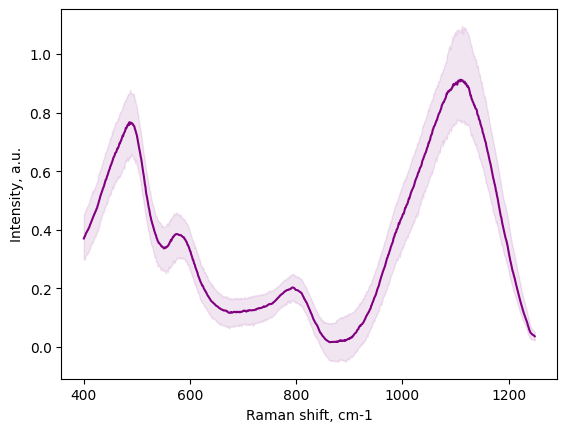

In [31]:
T_range = np.arange(T_start, T_stop, 1.0)

# warning : for viscosity you need to duplicate the composition array to get as many lines as the lenght of T_range
# of course it is simpler for other predictions, no need to do that.
viscosity = imelt_model.predict(equation,composition*np.ones((len(T_range),39)),T_range.reshape(-1,1))

# below we activate sampling, to get MC Dropout estimates of error bars.
# those are not corrected by conformal predictions (see paper for details and implications)
tg = imelt_model.predict("tg",composition, sampling=True, n_sample=20)
sctg = imelt_model.predict("sctg", composition, sampling=True, n_sample=20)
fragility = imelt_model.predict("fragility", composition, sampling=True, n_sample=20)
density = imelt_model.predict("density_glass", composition, sampling=True, n_sample=20)
ri = imelt_model.predict("sellmeier", composition, [589.0], sampling=True, n_sample=20)

A_TVF = imelt_model.predict("a_tvf", composition, sampling=True, n_sample=20)
B_TVF = imelt_model.predict("b_tvf", composition, sampling=True, n_sample=20)
C_TVF = imelt_model.predict("c_tvf", composition, sampling=True, n_sample=20)

raman = imelt_model.predict("raman_pred", composition, sampling=True, n_sample=20)

print('')
print('Results for composition with mol fractions')
print('{} SiO2, {} Al2O3, {} Na2O, {} K2O, {} MgO, {} CaO'.format(composition[0,0],composition[0,1],composition[0,2],
                                                                 composition[0,3],composition[0,4],composition[0,5]))
print('')
print('Tg is of {:.0f} +/- {:.0f}'.format(tg.mean(axis=1)[0], tg.std(axis=1)[0]))
print('Sconf at Tg is of {:.1f} +/- {:.1f}'.format(sctg.mean(axis=1)[0], sctg.std(axis=1)[0]))
print('')
print('Fragility is of {:.1f} +/- {:.1f}'.format(fragility.mean(axis=1)[0], fragility.std(axis=1)[0]))
print('Density is of {:.3f} +/- {:.3f}'.format(density.mean(axis=1)[0], density.std(axis=1)[0]))
print('Refractive Index at 598 nm is of {:.3f} +/- {:.3f}'.format(ri.mean(axis=1)[0], ri.std(axis=1)[0]))
print('')
print('Parameter A for VFT is of {:.2f}'.format(A_TVF.mean(axis=1)[0]))
print('Parameter B for VFT is of {:.1f}'.format(B_TVF.mean(axis=1)[0]))
print('Parameter C for VFT is of {:.1f}'.format(C_TVF.mean(axis=1)[0]))

#
# Plotting the Raman spectra
#
plt.figure()
# median spectrum for this composition
plt.plot(ds.x_raman_shift,np.quantile(raman, 0.50, axis=2).ravel(), c="purple")

# and we plot the shaded area between the 2.5 and 97.5 confidence intervals
plt.fill_between(ds.x_raman_shift, 
                 np.quantile(raman, 0.025, axis=2).ravel(), # low boundary (2.5 quantile)
                 np.quantile(raman, 0.975, axis=2).ravel(), # high boundary (97.5 quantile)
                 alpha=0.1, color="purple") 
plt.xlabel("Raman shift, cm-1")
plt.ylabel("Intensity, a.u.")
plt.show()